# Evaluation Advection diffusion

In [18]:
import os
import yaml
import json

import torch

from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np

from src.nnets.utils import load_model
from src.data_loader.data_loader import get_data_loader
from src.data_loader.config_data_loader import SimulatorDataset
from src.forward_models.init_physics_model import init_physics_solver_model
from src.metrics.mmd import MMDLoss, RBF, estimate_mmd_bandwidth
from src.evaluation.evaluator import one_to_many_evaluation



In [19]:
task_name = "advdiff"
test_exp_name = "d29419fcc0c9a39ce8905e178bec7848"
dataset_file_path = f"../../../datasets/forward_models/advdiff/one_to_many/testing/data_{test_exp_name}"
path_model_file = f"../../../outputs/best_models/advdiff/many_modes/joint/c2st/ot/gb/seed-13/52436e11b2400e2f7096ce284b571cd9/5l6a_score_0.5414_epoch_-1/model_1a956b9ebedbc6e66e00188f1caf80fa_exp_52436e11b2400e2f7096ce284b571cd9_7294c286476eee876c2339f2ad3c5e4c_salt_5l6a_best.pt"
#outputs/best_models/advdiff/7294c/marginal_score/c2st/27_10_24/52436e11b2400e2f7096ce284b571cd9/model_91edc8e76bbab82473c3ff1645dad5b5_exp_52436e11b2400e2f7096ce284b571cd9_7294c286476eee876c2339f2ad3c5e4c_salt_Xeqn_final_score_0.6172_-1.pt

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(13)
np.random.seed(13)

# Load the model
params_dim = 1
T_model, parent_dir, config, _ = load_model(
    path_model_file=path_model_file,
    params_dim=params_dim,
)

test_dataset = SimulatorDataset(
    name_dataset=task_name,
    data_file_path=dataset_file_path,
    testing_set=True,
    device=device,
)
test_loader = get_data_loader(
    test_dataset, batch_size=512
)  # batch size can be adjusted
bandwidth = estimate_mmd_bandwidth(test_loader, median_heuristic=True)

rbf = RBF(bandwidth=bandwidth, n_kernels=6, device=device)
metrics = [MMDLoss(kernel=rbf)]

Loading model from ../../../outputs/best_models/advdiff/many_modes/joint/c2st/ot/gb/seed-13/52436e11b2400e2f7096ce284b571cd9/5l6a_score_0.5414_epoch_-1/model_1a956b9ebedbc6e66e00188f1caf80fa_exp_52436e11b2400e2f7096ce284b571cd9_7294c286476eee876c2339f2ad3c5e4c_salt_5l6a_config.yaml
NeuralAdvDiff(
  (nnet): AdvDiffNNet(
    (conv_input): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=(1,))
    (fc_context_input): Linear(in_features=7, out_features=4, bias=True)
    (fc1): Linear(in_features=80, out_features=128, bias=True)
    (h_blocks): ModuleList(
      (0-1): 2 x Linear(in_features=128, out_features=128, bias=True)
    )
    (context_blocks): ModuleList(
      (0-2): 3 x Linear(in_features=7, out_features=128, bias=True)
    )
    (output_layer): Linear(in_features=128, out_features=20, bias=True)
  )
)
Loading model from ../../../outputs/best_models/advdiff/many_modes/joint/c2st/ot/gb/seed-13/52436e11b2400e2f7096ce284b571cd9/5l6a_score_0.5414_epoch_-1/model_1a956b9ebedbc6e66e0

In [21]:
test_samples = test_loader.sample()
test_params = test_samples["params"]
test_sims = test_samples["x"]
x_dim = test_sims.shape[2:]
test_init_conds = test_samples["init_conds"]
print(test_params.shape)
print(test_init_conds.shape)
print(test_sims.shape)
# Retrieve the parameters and initial conditions for the incomplete model
noisy_samples = test_params.shape[
    1
]  # number of stochastic samples
print(f"Test number of noisy samples per parameter: {noisy_samples}" )


torch.Size([500, 5, 20, 2])
torch.Size([500, 5, 20])
torch.Size([500, 5, 20, 50])
Test number of noisy samples per parameter: 5


In [22]:
X_params = test_params[
    :, ::noisy_samples, :, :params_dim
].squeeze(1)

X_init_conds = test_init_conds[:, ::noisy_samples].squeeze(
    1
)
phys_solver = init_physics_solver_model(config=config, device=device)
res_sims = phys_solver(init_conds=X_init_conds, params=X_params)
X_sims = res_sims["x"]
# Print shapes
print(X_params.shape)
print(X_init_conds.shape)
print(X_sims.shape)

torch.Size([500, 20, 1])
torch.Size([500, 20])
torch.Size([500, 20, 50])


## OT OdeNET

In [23]:
T_noisy_samples = noisy_samples
pred = T_model.predict(X_sims, context=X_params, z_samples=T_noisy_samples)
pred = pred.reshape((-1, T_noisy_samples) + (x_dim))
pred = pred.reshape((-1, T_noisy_samples) + (x_dim))

338
Simple Model parameters 
tensor([0.0229], device='cuda:0')
Complete Model parameters 
tensor([[0.0229, 0.0204],
        [0.0229, 0.0272],
        [0.0229, 0.0317],
        [0.0229, 0.0456],
        [0.0229, 0.0532]], device='cuda:0')


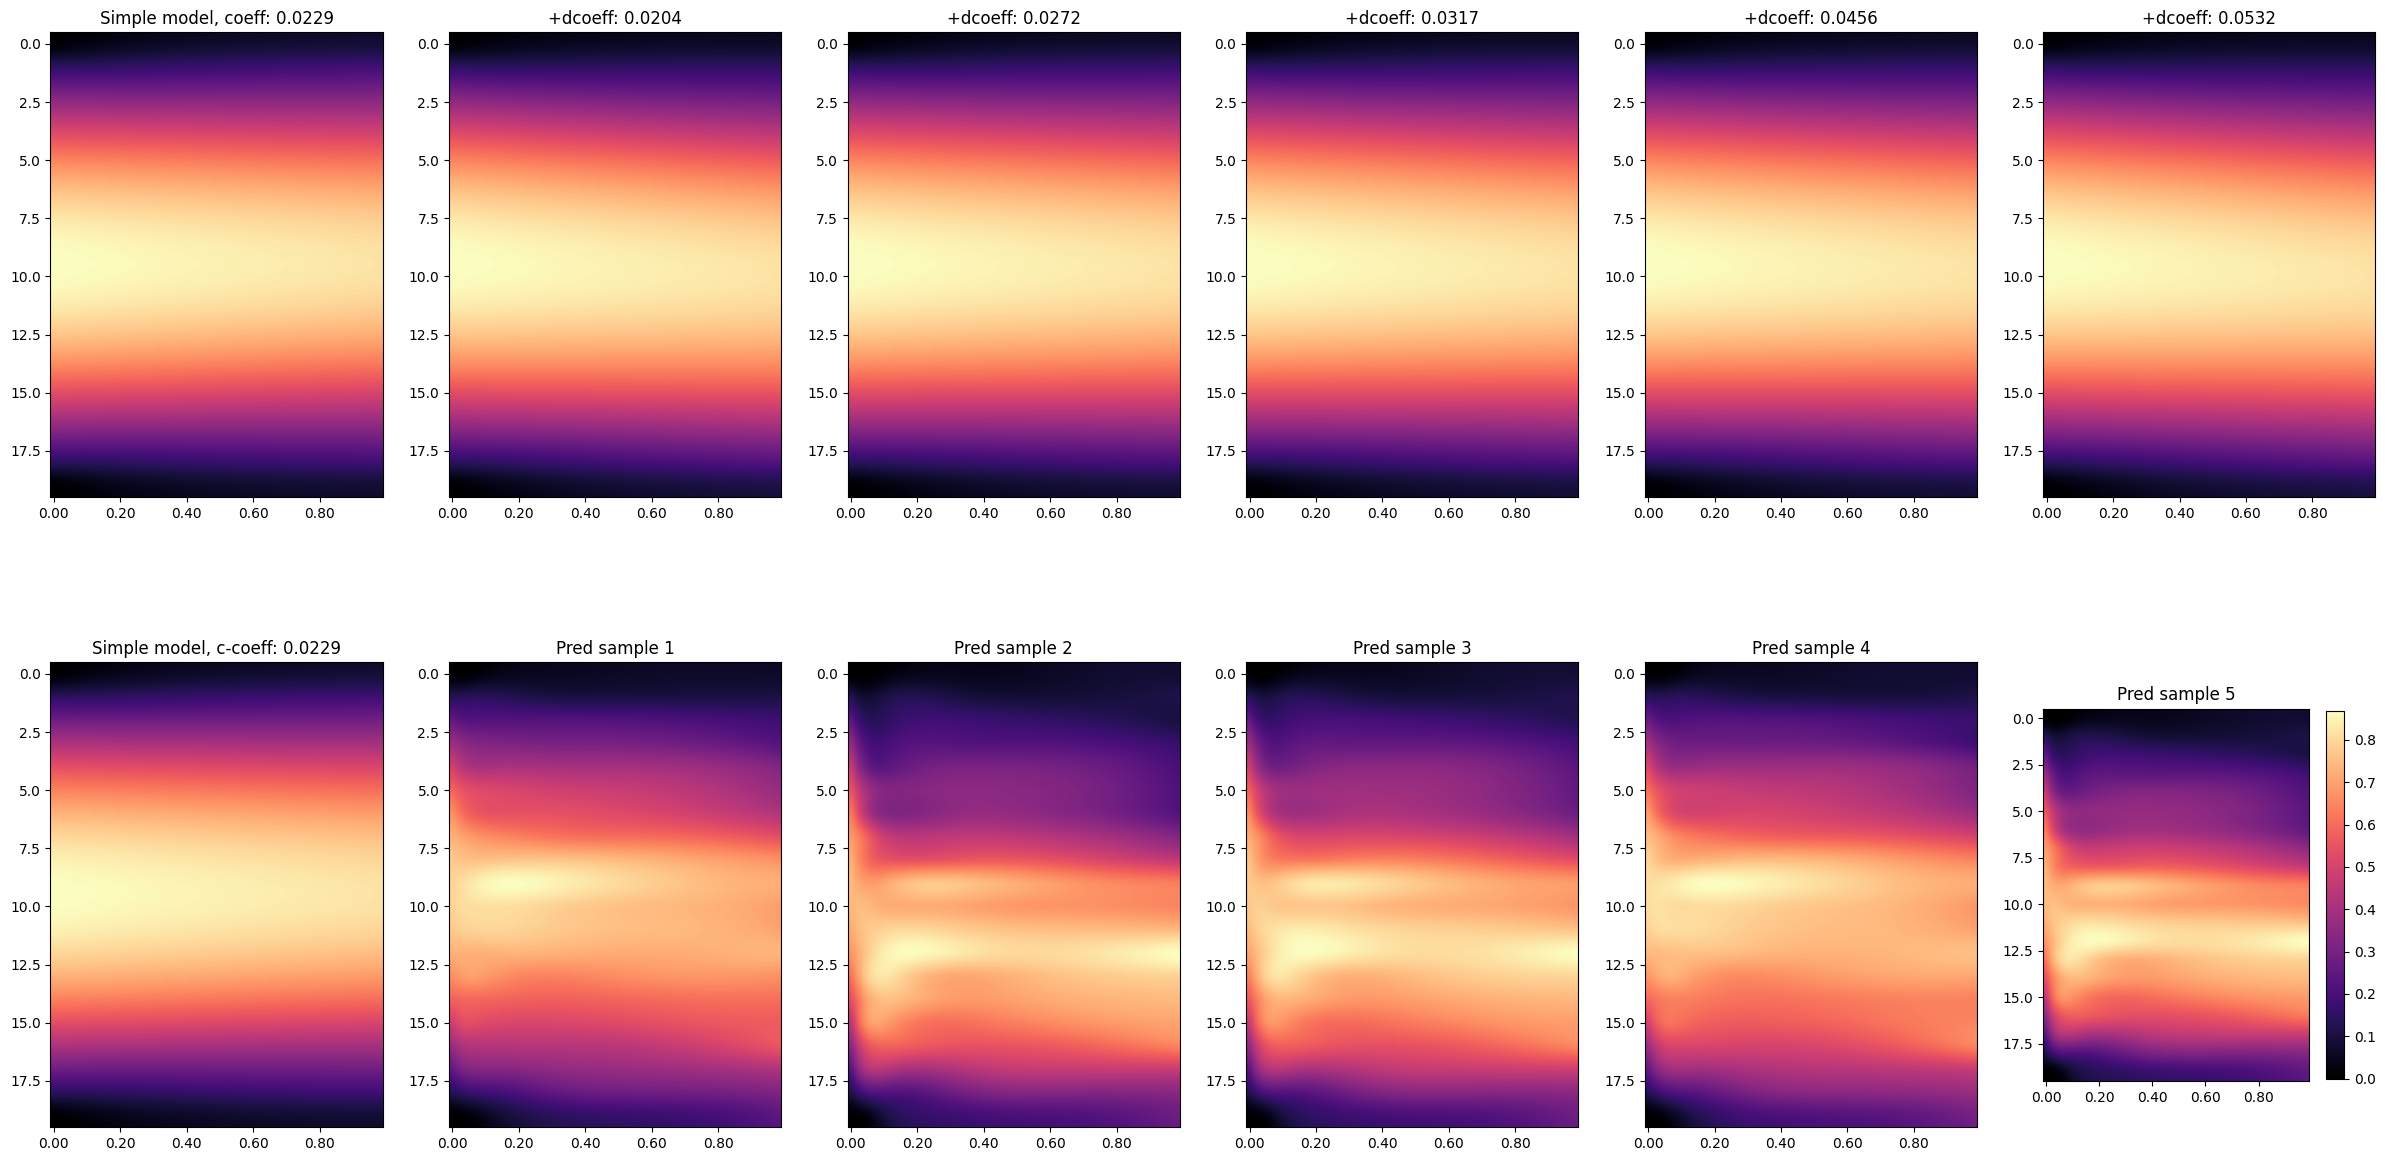

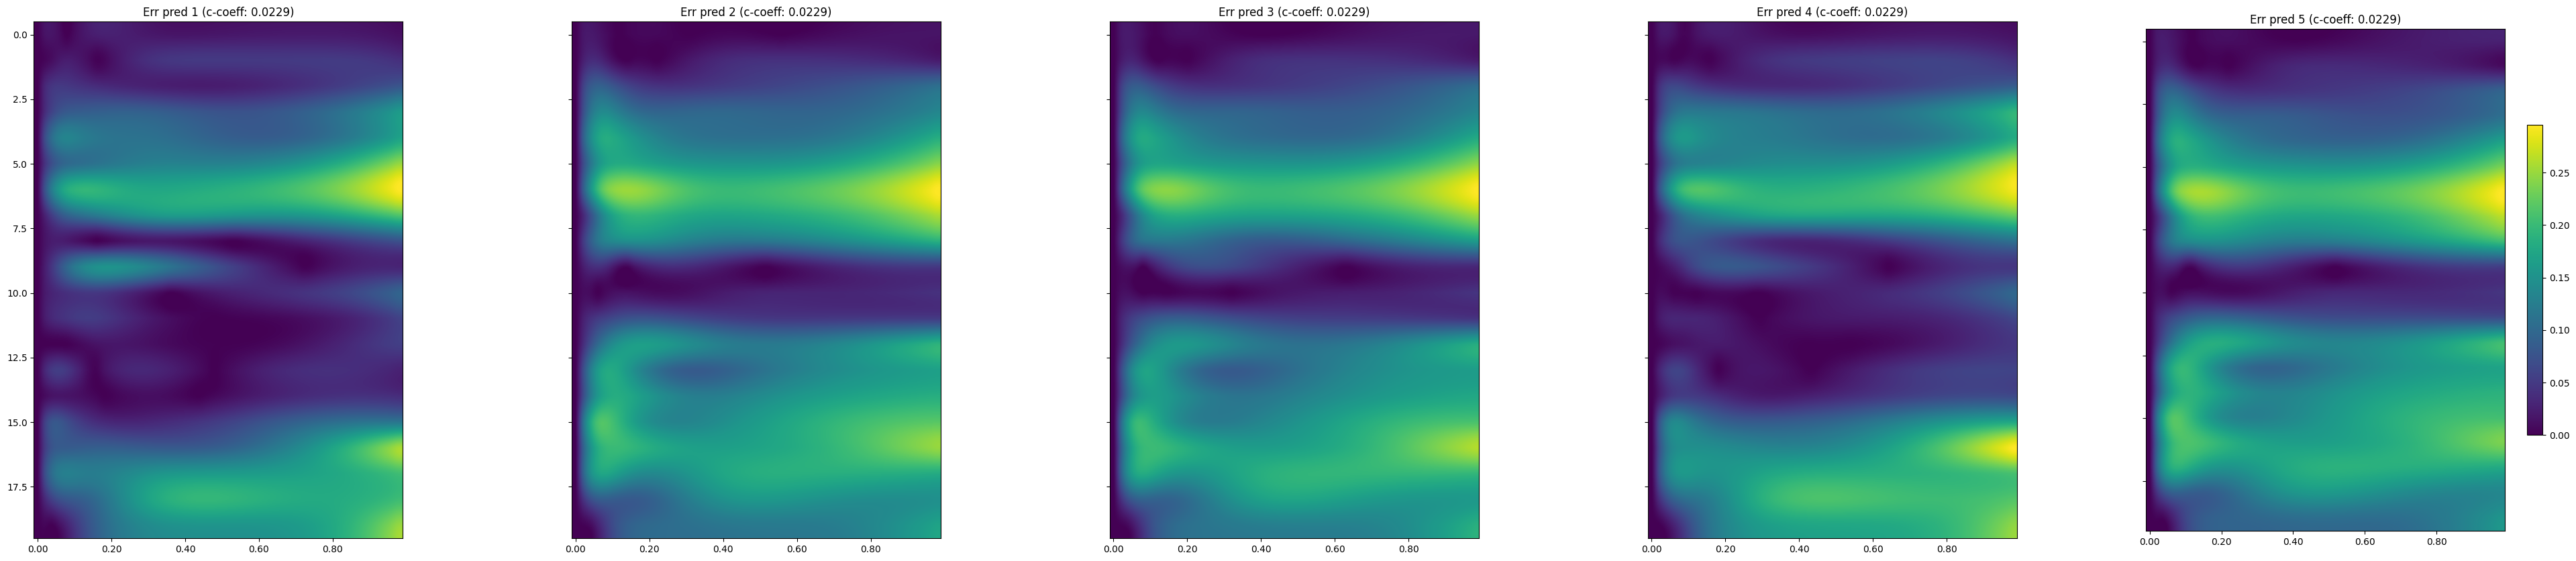

In [24]:
plot_samples = 1
xi = list(range(X_sims.shape[-1]))
x_labels = T_model.t_intg.detach().cpu().tolist()
x_labels = ["%.2f"%item for item in x_labels]

save_path = f"../../../outputs/figures/advdiff/{test_exp_name}"
os.makedirs(save_path, exist_ok=True)

for j in range(0, plot_samples):
    random_idx = np.random.randint(0, X_sims.shape[0])
    print(random_idx)
    kwargs = {'vmin':0.0, 'aspect':3.5, 'cmap':'magma', 'interpolation':'spline16'}
    kwargs_err = {'aspect':3.5, 'cmap':'viridis', 'interpolation':'spline16'}
    fig, axes = plt.subplots(2, noisy_samples+1, figsize=(30, 15))

    param_0 = X_params.reshape(-1, 20)[random_idx].unique()
    print(f"Simple Model parameters \n{param_0}")
    c_params = test_params[random_idx, :, 0].unique(dim=0)
    print(f"Complete Model parameters \n{c_params}")
    #x axis format

    axes[0, 0].imshow(X_sims[random_idx].detach().cpu().numpy(), **kwargs)
    axes[0, 0].set_xticks(xi, x_labels, minor=False)
    axes[0, 0].locator_params(axis='x', nbins=5)
    axes[0, 0].set_title(f"Simple model, coeff: {param_0.item():.4f}")
    # set x_axis range to be  T_model.t_intg.detach().cpu().tolist()
    # axes[0, 0].set_xscale('function', functions=(lambda x: x, lambda x: x))

    axes[1, 0].imshow(X_sims[random_idx].detach().cpu().numpy(), **kwargs)
    axes[1, 0].set_xticks(xi, x_labels, minor=False)
    axes[1, 0].locator_params(axis='x', nbins=5)
    axes[1, 0].set_title(f"Simple model, c-coeff: {param_0.item():.4f}")

    fig_err, axes_err = plt.subplots(1, noisy_samples, figsize=(50, 10), sharey=True)

    for i in range(noisy_samples):
        # Target
        axes[0, i+1].imshow(test_sims[random_idx, i].detach().cpu().numpy(), **kwargs)
        axes[0, i+1].set_xticks(xi, x_labels, minor=False)
        axes[0, i+1].locator_params(axis='x', nbins=5)
        axes[0, i+1].set_title(f"+dcoeff: {c_params[i][1]:.4f}")
        
        # Prediction
        pos = axes[1, i+1].imshow(pred[random_idx, i].detach().cpu().numpy(), **kwargs)
        axes[1, i+1].set_xticks(xi, x_labels, minor=False)
        axes[1, i+1].locator_params(axis='x', nbins=5)
        axes[1, i+1].set_title(f"Pred sample {i+1}")

        # error
        err = torch.abs(pred[random_idx, i] - test_sims[random_idx, i])
        pos_err = axes_err[i].imshow(err.detach().cpu().numpy(), **kwargs_err)
        axes_err[i].set_xticks(xi, x_labels, minor=False)
        axes_err[i].locator_params(axis='x', nbins=5)
        axes_err[i].set_title(f"Err pred {i+1} (c-coeff: {param_0.item():.4f})")
    
    fig.colorbar(pos, ax=axes[1, -1], location='right', shrink=0.7)
    fig_err.colorbar(pos_err, ax=axes_err[-1], location='right',  shrink=0.6)
    # save err
    fig_err.savefig(f"{save_path}/sample_{random_idx}_err.png")
    plt.show()


In [20]:
del pred

## Extrapolation

In [25]:
# change model's integrator setting
T_model.len_episode = (2) * T_model.len_episode 
print(f"Extrapolatin of {T_model.len_episode} steps")
T_model.t_intg = torch.linspace(0.0, T_model.dt* T_model.len_episode, T_model.len_episode, device=T_model.device)
print(f"Max time: {T_model.t_intg.max()}")

with torch.no_grad():
    extr_pred = T_model.predict(X_sims, context=X_params, z_samples=T_noisy_samples)
    extr_pred = extr_pred.reshape((-1, T_noisy_samples) + (extr_pred.shape[1:]))
    #pred = pred.reshape((-1, T_noisy_samples) + (x_dim))
    print(extr_pred.shape)

Extrapolatin of 50 steps
Max time: 0.9800000190734863
torch.Size([500, 5, 20, 50])


In [11]:
print(test_params.shape)
x_grid_dim = test_params.shape[2]
params = test_params.reshape(-1, x_grid_dim, 2)
new_init_conds = X_init_conds.reshape(-1, 1, x_grid_dim).repeat(1, 5,1)
new_init_conds = new_init_conds.reshape(-1, x_grid_dim)
print(params.shape, new_init_conds.shape)

torch.Size([500, 5, 20, 2])
torch.Size([2500, 20, 2]) torch.Size([2500, 20])


In [12]:
# complete_model
phys_solver.len_episode = T_model.len_episode
phys_solver.dt = T_model.dt
phys_solver.t = T_model.t_intg


res_extr_Y = phys_solver(init_conds=new_init_conds, params=params)
Y_extr = res_extr_Y["x"].reshape(-1, noisy_samples, x_grid_dim, phys_solver.len_episode)
params = params.reshape(-1, noisy_samples, x_grid_dim, 2)


In [13]:
print(extr_pred.shape, Y_extr.shape)
assert torch.isclose(extr_pred.reshape(-1, 20, extr_pred.shape[-1])[:, :, 0], Y_extr.reshape(-1, 20, Y_extr.shape[-1])[:, :, 0]).all()

torch.Size([500, 5, 20, 200]) torch.Size([500, 5, 20, 200])


In [14]:
params.shape

torch.Size([500, 5, 20, 2])

483
Simple Model parameters 
tensor([0.0437], device='cuda:0')
Complete Model parameters 
tensor([[0.0437, 0.0204],
        [0.0437, 0.0272],
        [0.0437, 0.0317],
        [0.0437, 0.0456],
        [0.0437, 0.0532]], device='cuda:0')
torch.Size([5, 2])


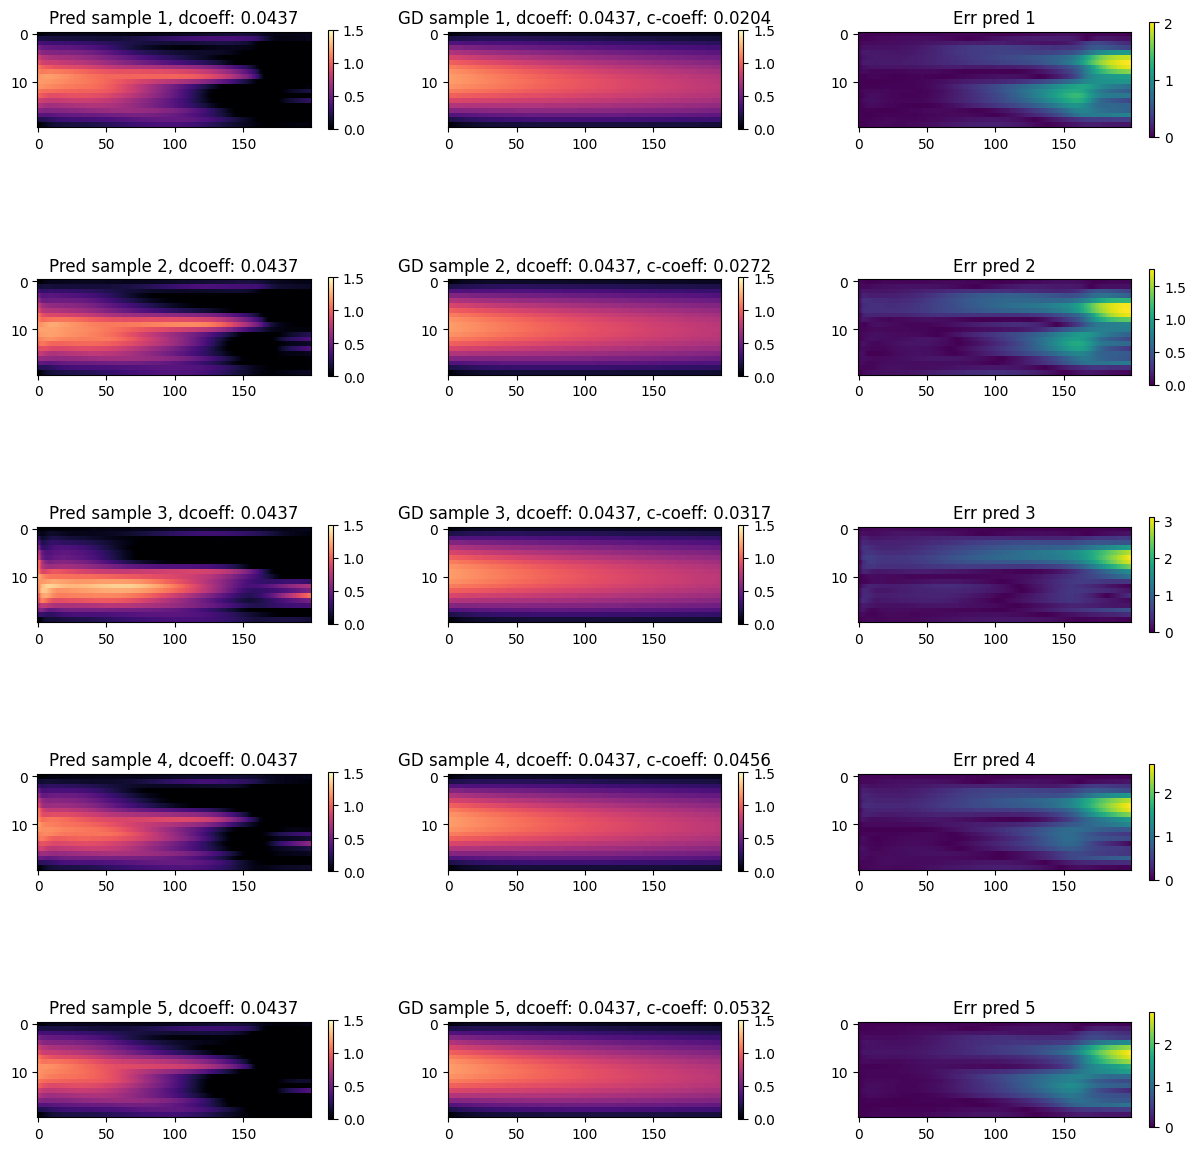

410
Simple Model parameters 
tensor([0.0908], device='cuda:0')
Complete Model parameters 
tensor([[0.0908, 0.0204],
        [0.0908, 0.0272],
        [0.0908, 0.0317],
        [0.0908, 0.0456],
        [0.0908, 0.0532]], device='cuda:0')
torch.Size([5, 2])


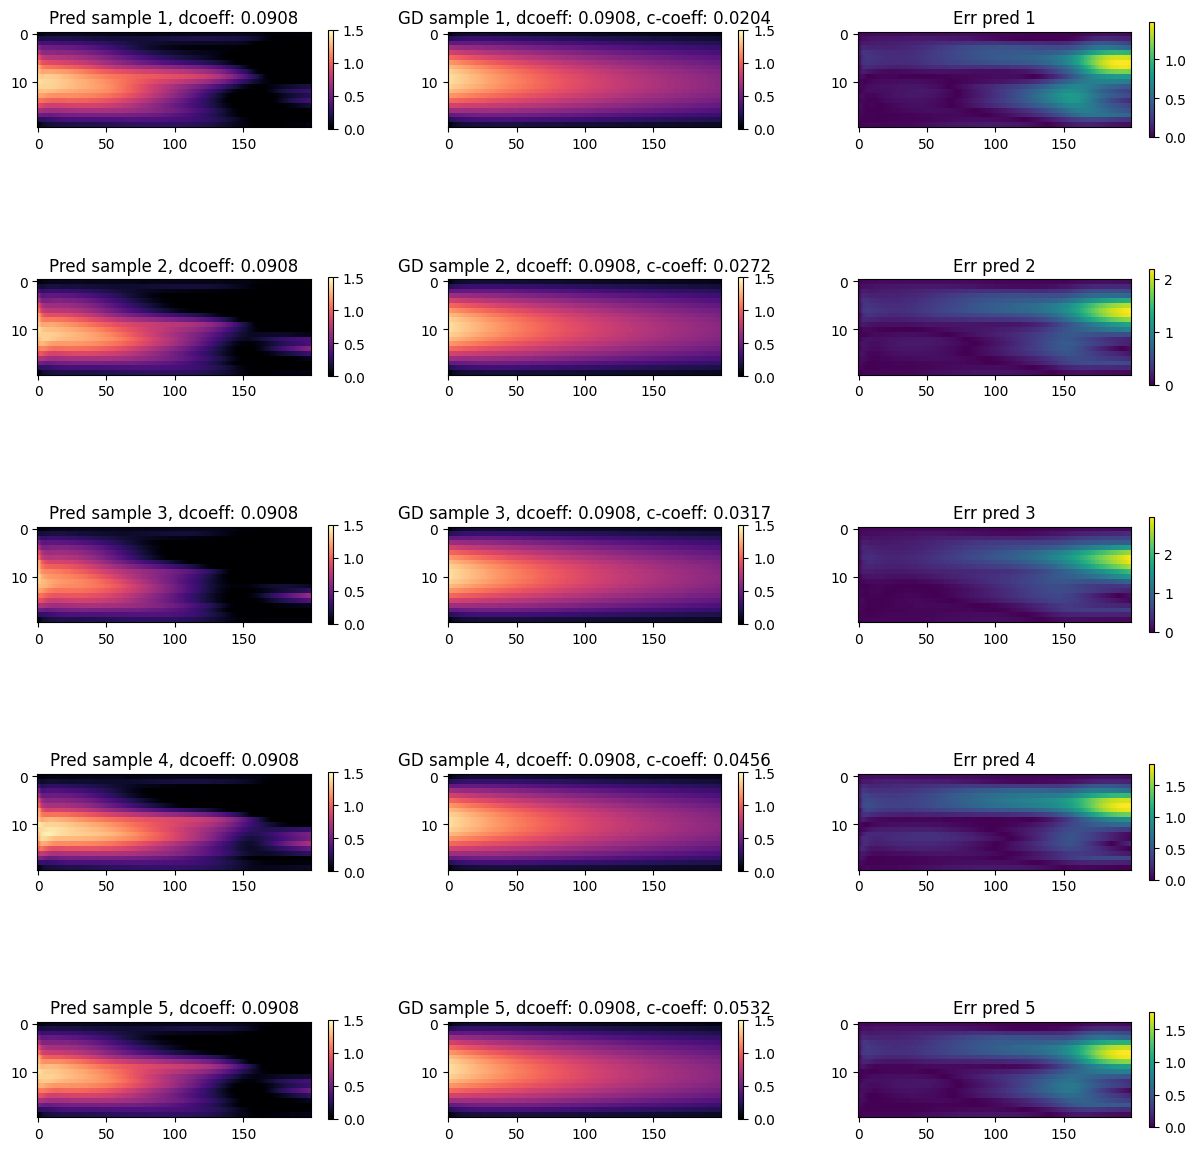

244
Simple Model parameters 
tensor([0.0769], device='cuda:0')
Complete Model parameters 
tensor([[0.0769, 0.0204],
        [0.0769, 0.0272],
        [0.0769, 0.0317],
        [0.0769, 0.0456],
        [0.0769, 0.0532]], device='cuda:0')
torch.Size([5, 2])


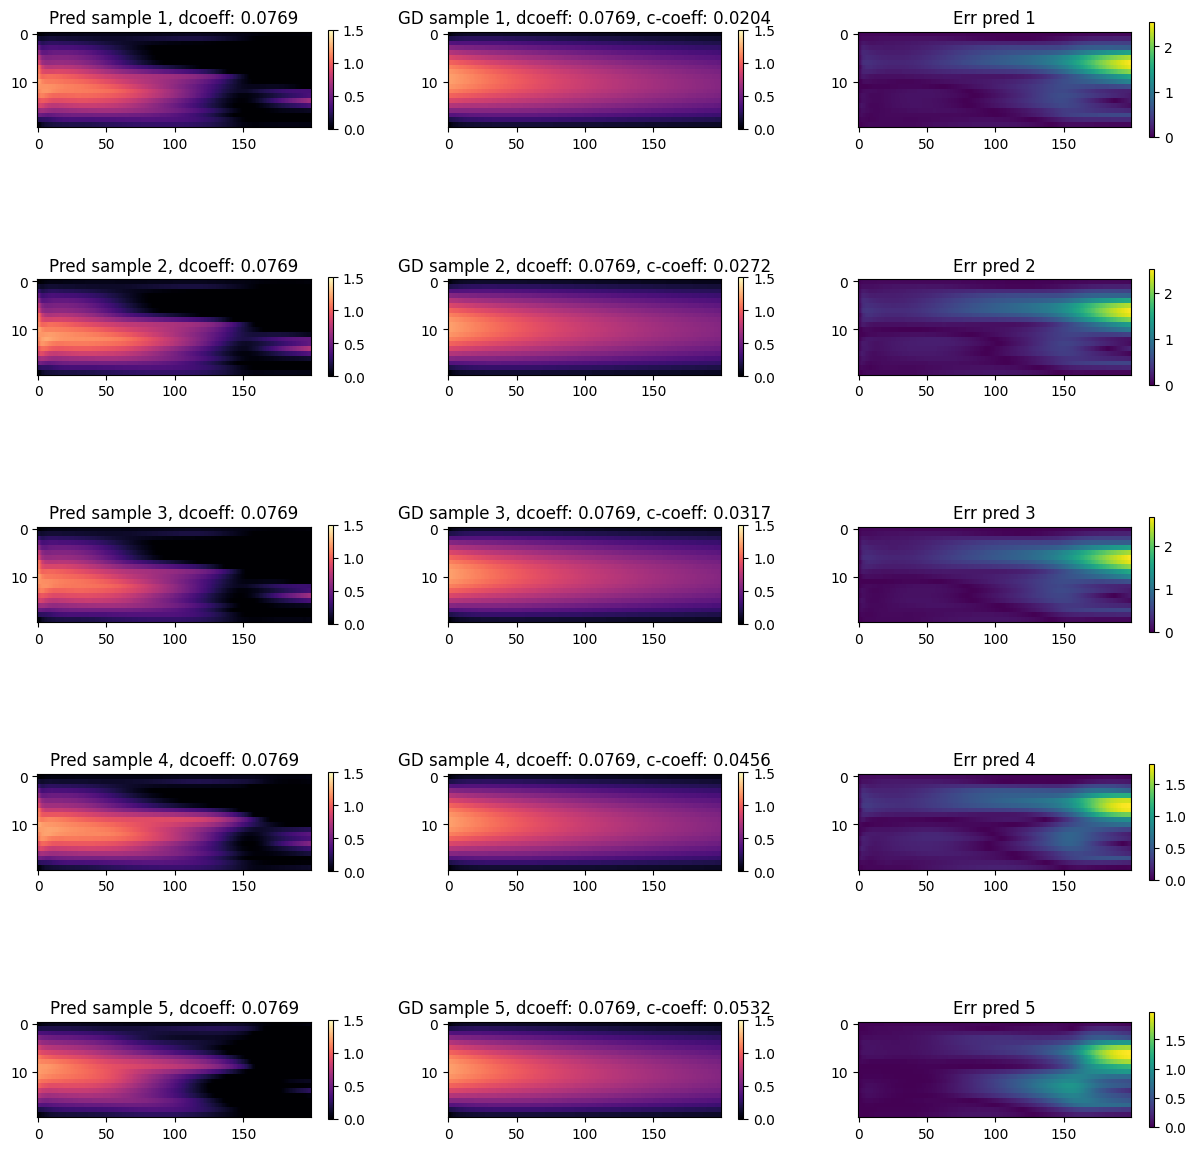

126
Simple Model parameters 
tensor([0.0751], device='cuda:0')
Complete Model parameters 
tensor([[0.0751, 0.0204],
        [0.0751, 0.0272],
        [0.0751, 0.0317],
        [0.0751, 0.0456],
        [0.0751, 0.0532]], device='cuda:0')
torch.Size([5, 2])


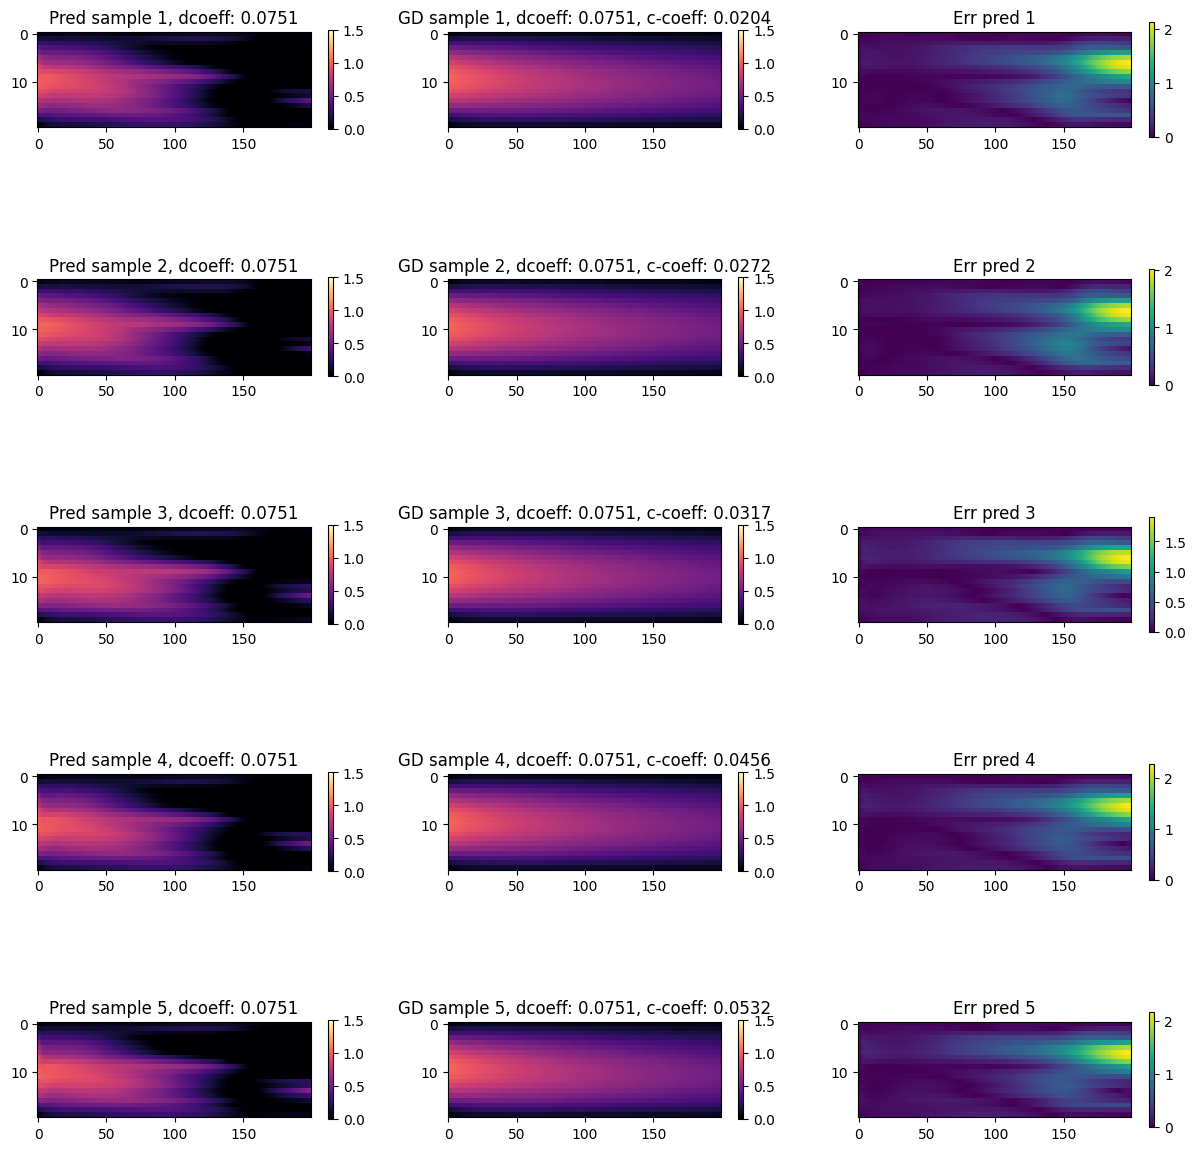

450
Simple Model parameters 
tensor([0.0530], device='cuda:0')
Complete Model parameters 
tensor([[0.0530, 0.0204],
        [0.0530, 0.0272],
        [0.0530, 0.0317],
        [0.0530, 0.0456],
        [0.0530, 0.0532]], device='cuda:0')
torch.Size([5, 2])


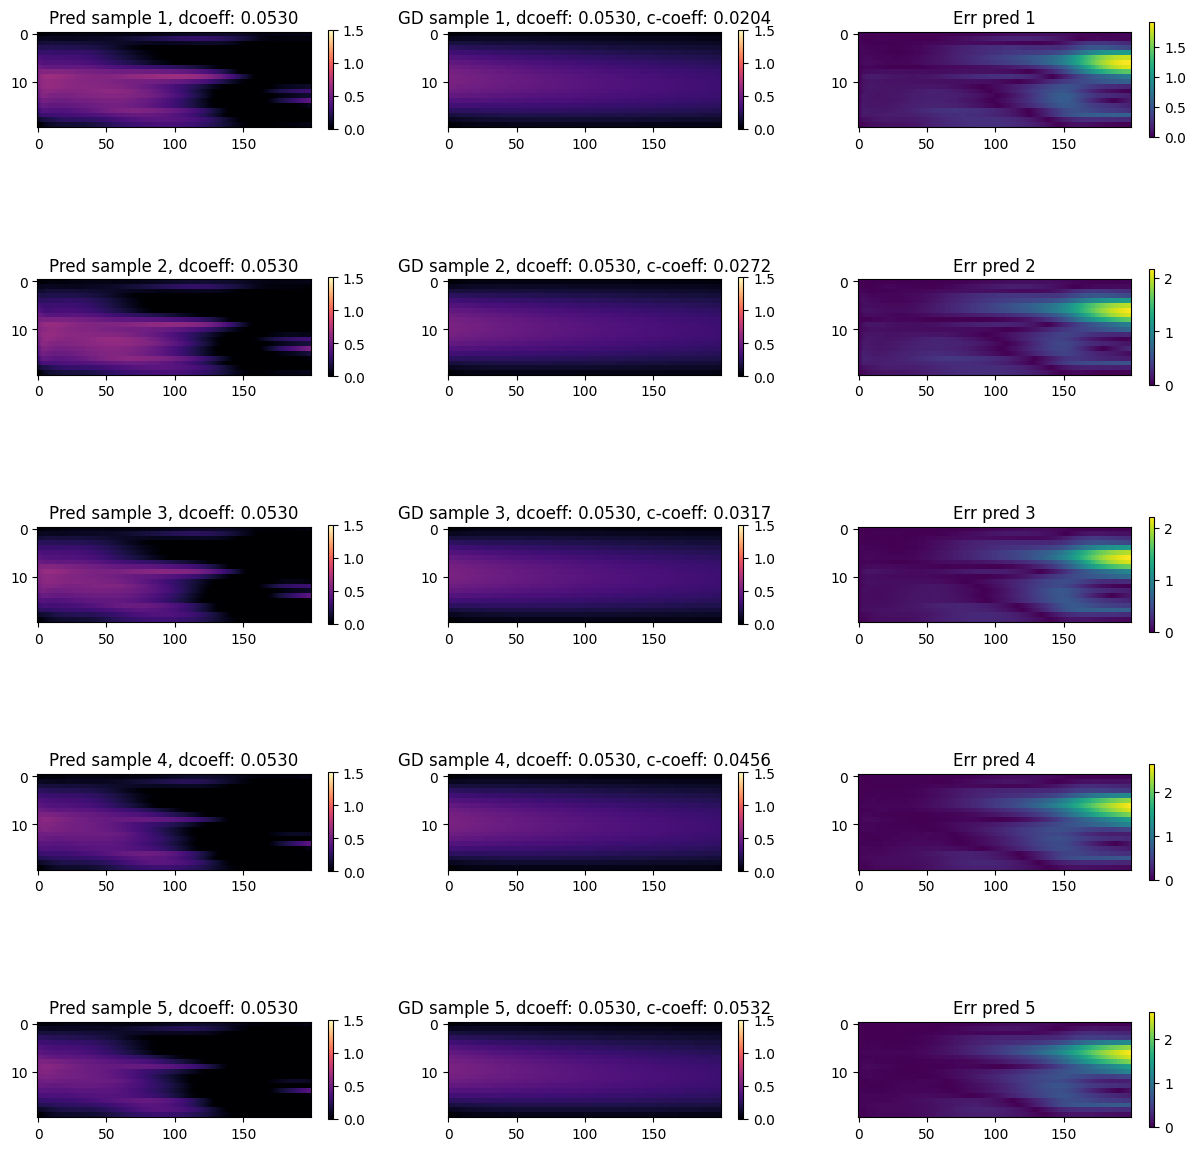

430
Simple Model parameters 
tensor([0.0486], device='cuda:0')
Complete Model parameters 
tensor([[0.0486, 0.0204],
        [0.0486, 0.0272],
        [0.0486, 0.0317],
        [0.0486, 0.0456],
        [0.0486, 0.0532]], device='cuda:0')
torch.Size([5, 2])


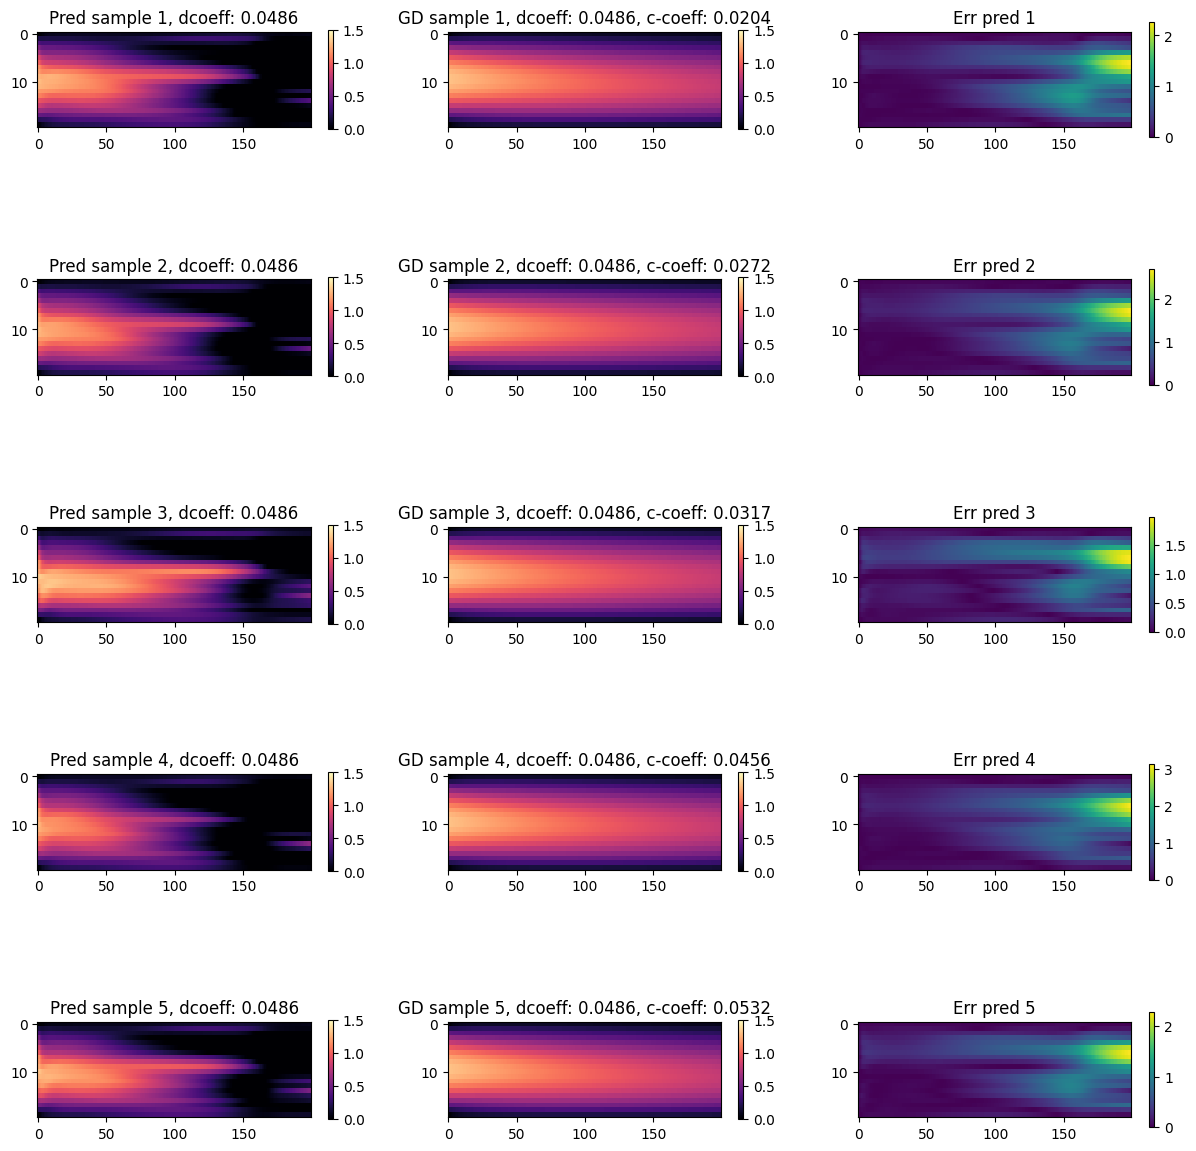

438
Simple Model parameters 
tensor([0.0623], device='cuda:0')
Complete Model parameters 
tensor([[0.0623, 0.0204],
        [0.0623, 0.0272],
        [0.0623, 0.0317],
        [0.0623, 0.0456],
        [0.0623, 0.0532]], device='cuda:0')
torch.Size([5, 2])


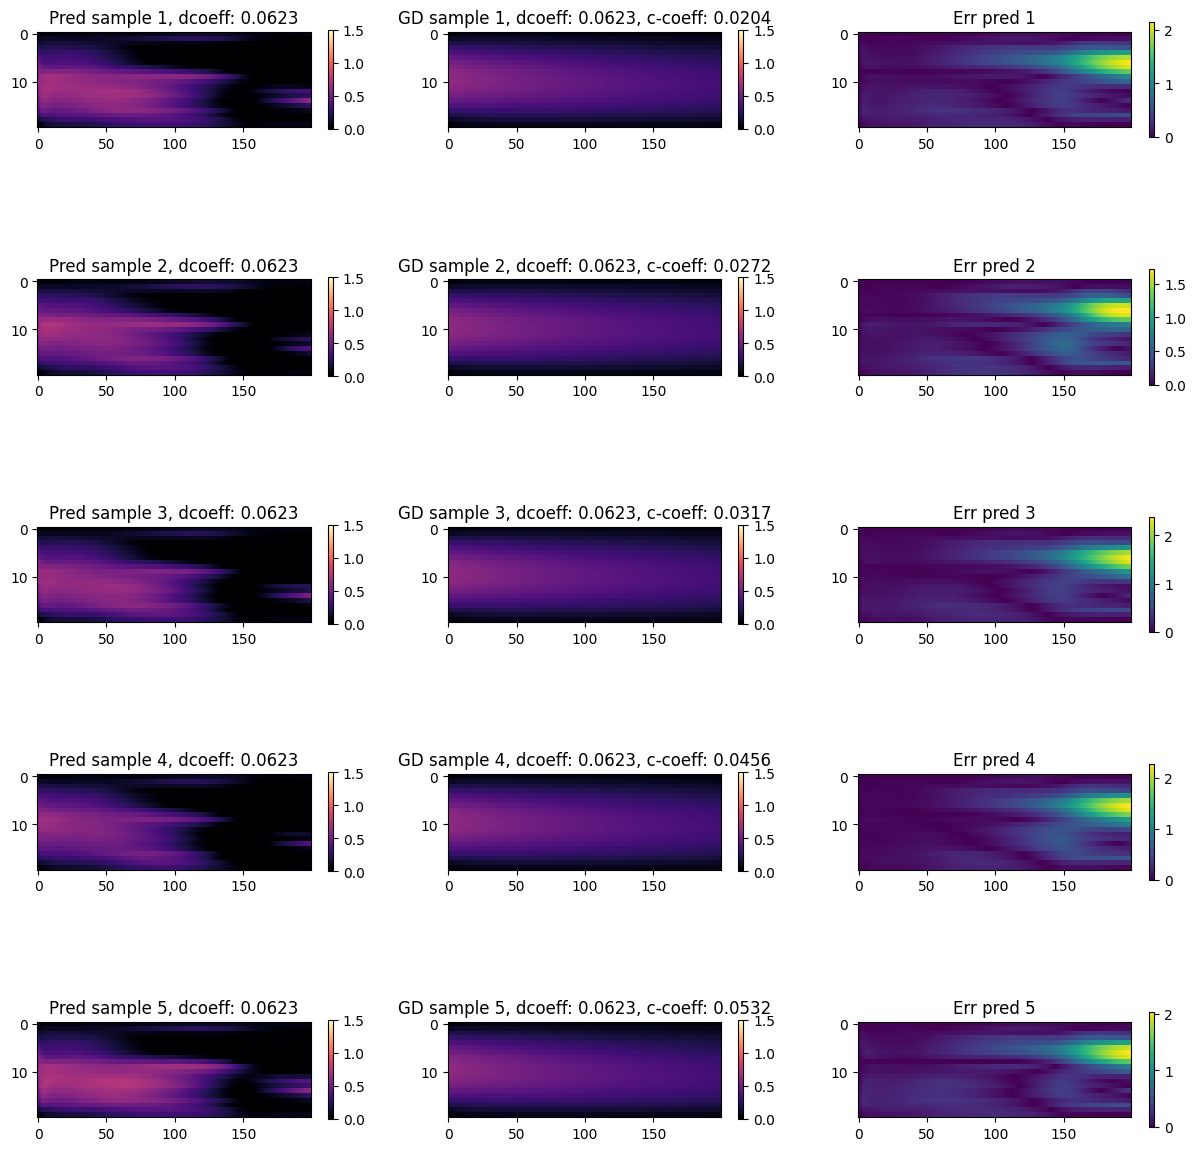

229
Simple Model parameters 
tensor([0.0303], device='cuda:0')
Complete Model parameters 
tensor([[0.0303, 0.0204],
        [0.0303, 0.0272],
        [0.0303, 0.0317],
        [0.0303, 0.0456],
        [0.0303, 0.0532]], device='cuda:0')
torch.Size([5, 2])


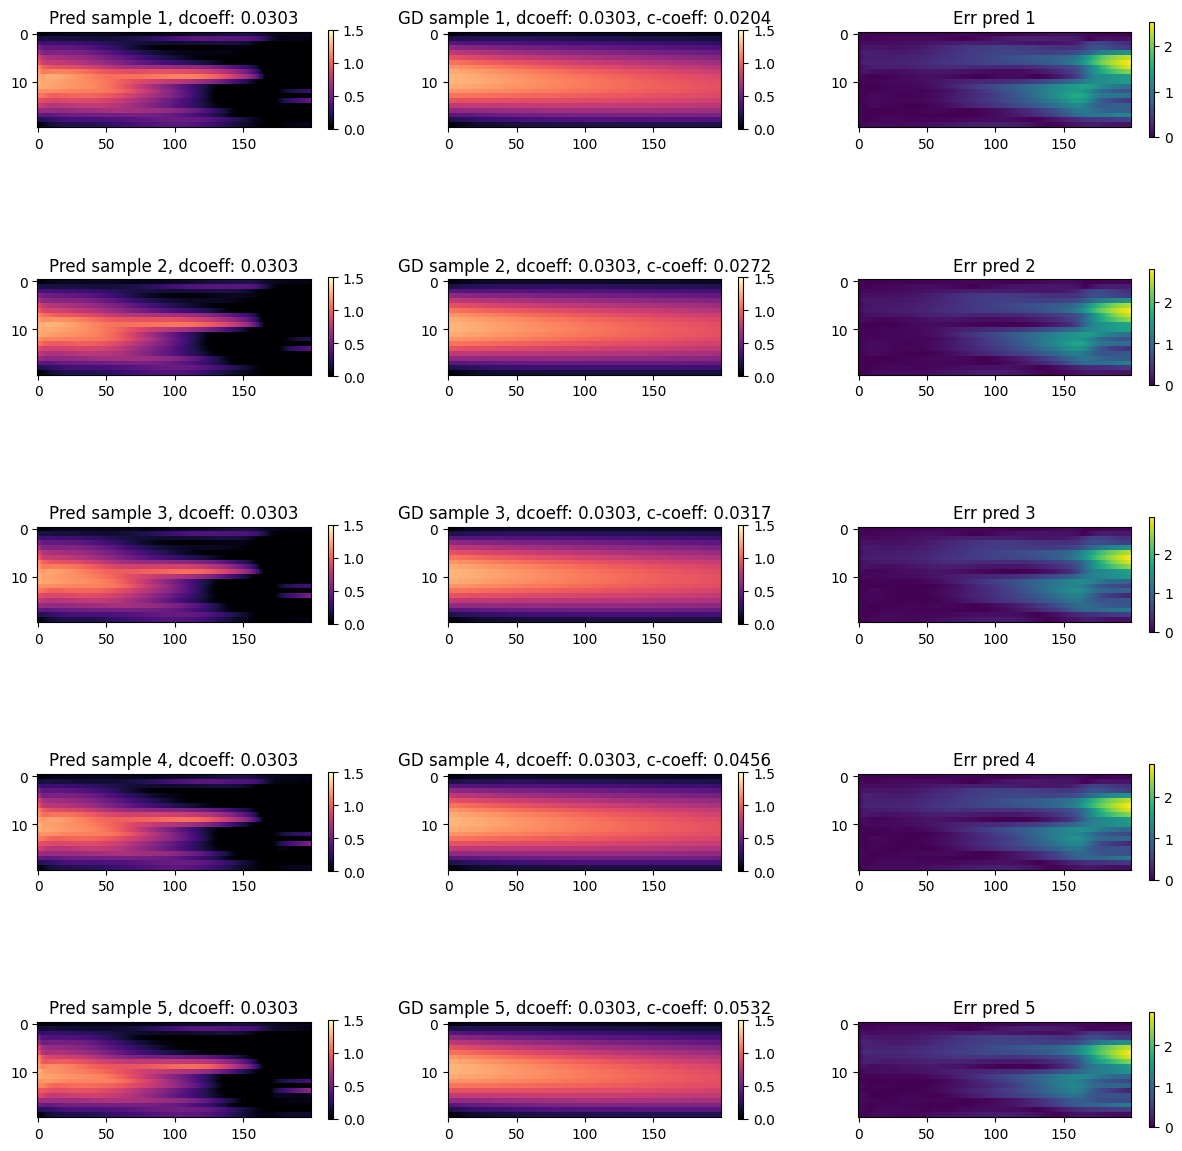

461
Simple Model parameters 
tensor([0.0887], device='cuda:0')
Complete Model parameters 
tensor([[0.0887, 0.0204],
        [0.0887, 0.0272],
        [0.0887, 0.0317],
        [0.0887, 0.0456],
        [0.0887, 0.0532]], device='cuda:0')
torch.Size([5, 2])


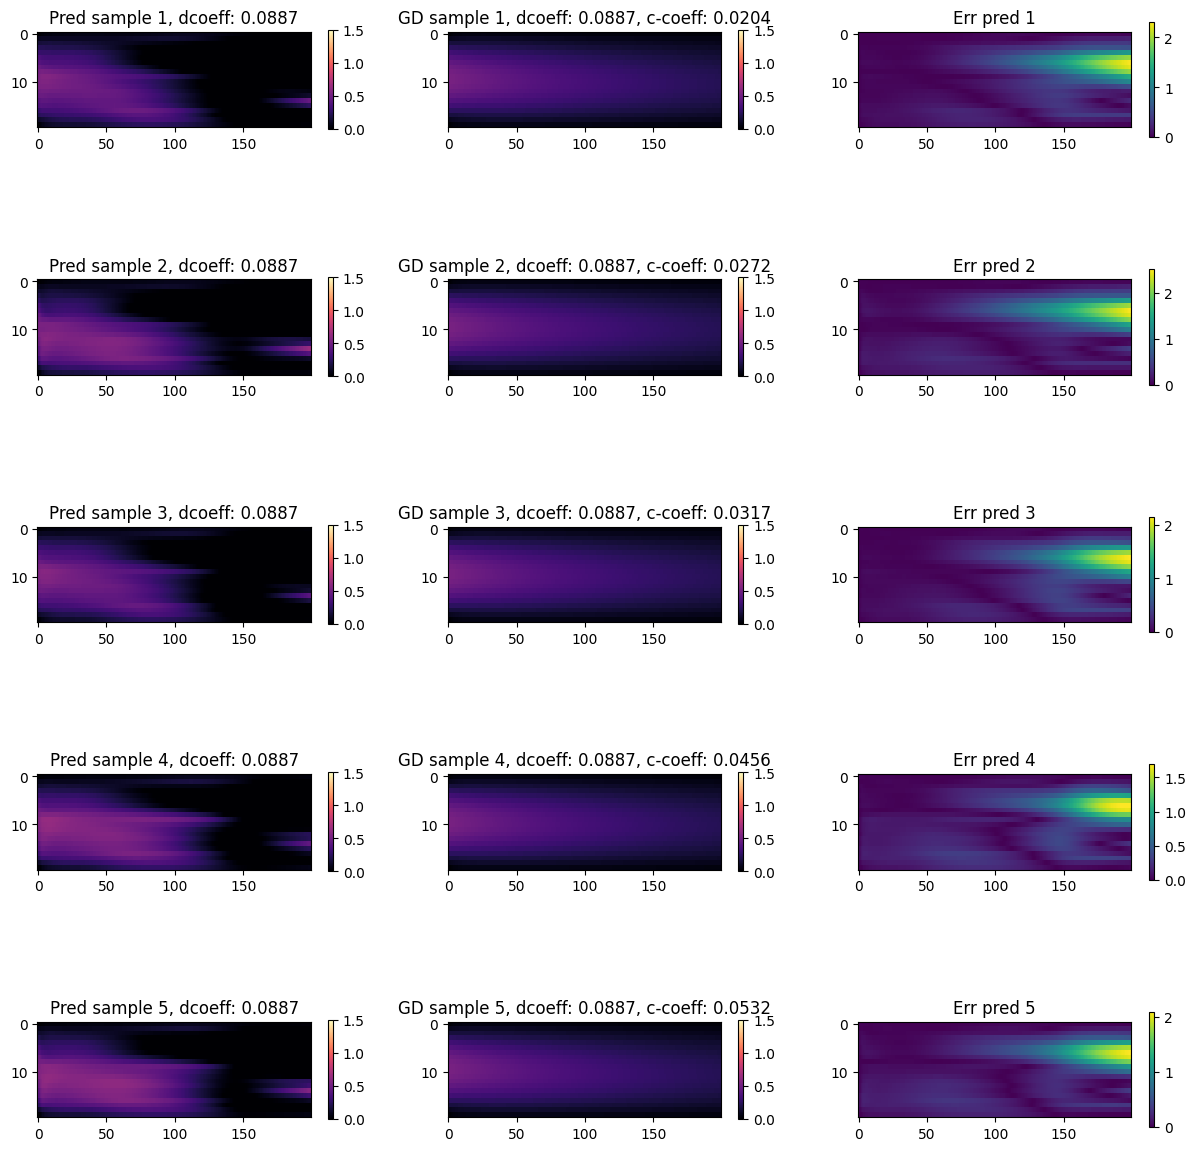

74
Simple Model parameters 
tensor([0.0853], device='cuda:0')
Complete Model parameters 
tensor([[0.0853, 0.0204],
        [0.0853, 0.0272],
        [0.0853, 0.0317],
        [0.0853, 0.0456],
        [0.0853, 0.0532]], device='cuda:0')
torch.Size([5, 2])


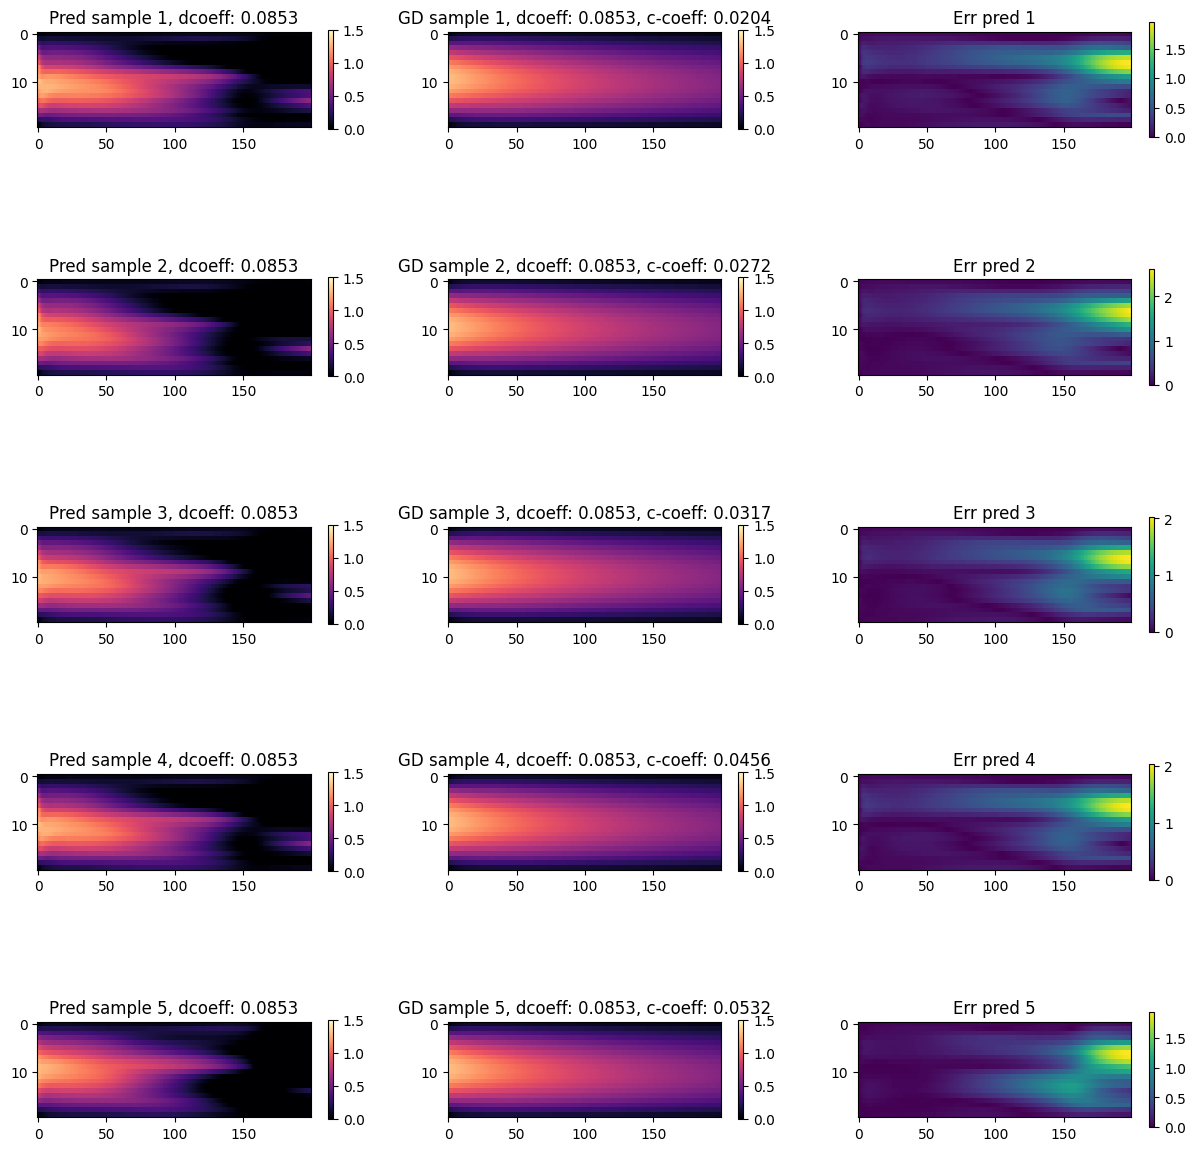

In [15]:
plot_samples = 10
#xi = list(range(extr_pred.shape[-1]))
x_labels = T_model.t_intg.detach().cpu().tolist()
x_labels = ["%.2f"%item for item in x_labels]
for j in range(0, plot_samples):
    random_idx = np.random.randint(0, extr_pred.shape[0])
    print(random_idx)
    
    fig, axes = plt.subplots(noisy_samples, 3, figsize=(15, 15))

    param_0 = X_params.reshape(-1, 20)[random_idx].unique()
    print(f"Simple Model parameters \n{param_0}")
    c_params = test_params[random_idx, :, 0].unique(dim=0)
    print(f"Complete Model parameters \n{c_params}")
    
    y_params_1 = params[random_idx, :, 0].unique(dim=0)
    print(y_params_1.shape)
    #x axis format

    kwargs_err = {'aspect':3.5, 'cmap':'viridis', 'interpolation':'none'}

    for i in range(noisy_samples):
        # Prediction
        #vmax = np.maximum(extr_pred[random_idx, i].max().item(), Y_extr[random_idx, i].max().item())
        kwargs = {'vmin':0.0, 'vmax': 1.5, 'aspect':3.5, 'cmap':'magma', 'interpolation':'none'}
        kwargs = {'vmin':0.0, 'vmax': 1.5, 'aspect':3.5, 'cmap':'magma', 'interpolation':'none'}
        pos = axes[i, 0].imshow(extr_pred[random_idx, i].detach().cpu().numpy(), **kwargs)
        #axes[i].set_xticks(xi, x_labels, minor=False)
        #axes[i].locator_params(axis='x', nbins=10)
        axes[i, 0].set_title(f"Pred sample {i+1}, dcoeff: {param_0.item():.4f}")
        fig.colorbar(pos, ax=axes[i, 0], location='right',  shrink=0.6)
        
        # Prediction
        pos = axes[i, 1].imshow(Y_extr[random_idx, i].detach().cpu().numpy(), **kwargs)
        #axes[i].set_xticks(xi, x_labels, minor=False)
        #axes[i].locator_params(axis='x', nbins=10)
        axes[i, 1].set_title(f"GD sample {i+1}, dcoeff: {param_0.item():.4f}, c-coeff: {y_params_1[i][1].tolist():.4f}")
        fig.colorbar(pos, ax=axes[i, 1], location='right',  shrink=0.6)

        # error
        err = torch.abs(extr_pred[random_idx, i] - Y_extr[random_idx, i])
        pos_err = axes[i, 2].imshow(err.detach().cpu().numpy(), **kwargs_err)
        axes[i, 2].set_title(f"Err pred {i+1}")

        fig.colorbar(pos_err, ax=axes[i, 2], location='right', shrink=0.7)
    
    #axes[0, 0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig.subplots_adjust(hspace=0.5)
    
    plt.show()